In [1]:
import numpy as np

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


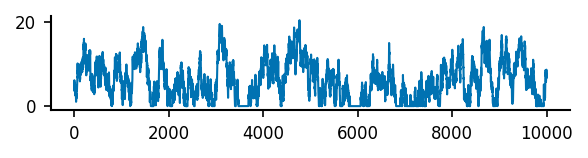

In [2]:
mean, sigma, tau = 5, 5, 10
tstop = 1000
dt = 0.1
OU = np.clip(OrnsteinUhlenbeck_Process(mean, sigma, tau, dt, tstop), 0, np.inf)

fig, ax = pt.figure(figsize=(2,1))
ax.plot(OU)

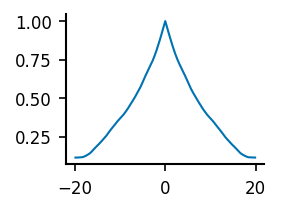

In [23]:
CCF, ts = crosscorrel(OU, OU, 20, dt)
plt.plot(ts, CCF)

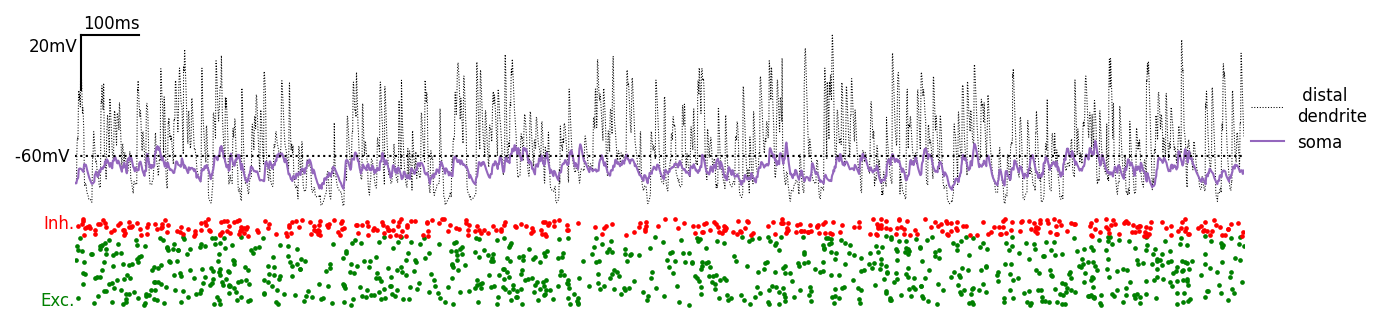

In [6]:
results = np.load('single_sim.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, AX = pt.figure(axes_extents=[[(1,2)],[(1,1)]],
                    figsize=(3,1), left=0, bottom=0., hspace=0.)
AX[0].plot(t, results['Vm_dend'], 'k:', lw=0.5, label=' distal\ndendrite')
AX[0].plot(t, results['Vm_soma'], 'tab:purple', label='soma')
AX[0].plot(t, -60+0*t, 'k:')
pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
AX[0].legend(frameon=False, loc=(1, 0.3))

for i, events in enumerate(results['presynaptic_exc_events']):
    AX[1].plot(events, i*np.ones(len(events)), '.', color='g')
for i, events in enumerate(results['presynaptic_inh_events']):
    AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
               color='r')
pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')

pt.set_common_xlims(AX, lims=[t[0], t[-1]])
for ax in AX:
    ax.axis('off')

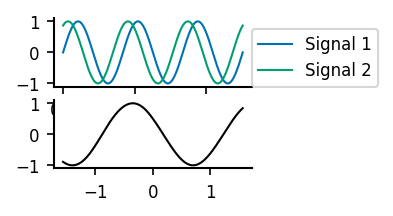

In [10]:
t = np.linspace(0, np.pi*2, int(1000))
Signal1 = np.sin(3*t)
Signal2 = np.cos(3*t-np.pi/6)
_, ax = plt.subplots(2)
ax[0].plot(t, Signal1, label='Signal 1')
ax[0].plot(t, Signal2, label='Signal 2')
ax[0].legend(loc=(1,0))
cr, t_shift = crosscorrel(Signal1, Signal2, np.pi/2., t[1]-t[0])
ax[1].plot(t_shift, cr, 'k-')



In [15]:
np.random.uniform?

Docstring:
uniform(low=0.0, high=1.0, size=None)

Draw samples from a uniform distribution.

Samples are uniformly distributed over the half-open interval
``[low, high)`` (includes low, but excludes high).  In other words,
any value within the given interval is equally likely to be drawn
by `uniform`.

.. note::
    New code should use the ``uniform`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
low : float or array_like of floats, optional
    Lower boundary of the output interval.  All values generated will be
    greater than or equal to low.  The default value is 0.
high : float or array_like of floats
    Upper boundary of the output interval.  All values generated will be
    less than or equal to high.  The high limit may be included in the 
    returned array of floats due to floating-point rounding in the 
    equation ``low + (high-low) * random_sample()``.  The default value 
    is 1.0.
size : int or tu